In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [15]:
# Загрузим датасет
df_aa = pd.read_csv('hw_aa.csv', sep=';')
# Удалим лишнюю колонку
del df_aa ['Unnamed: 0']
# Для читабельности переименнуем колонку experimentVariant
df_aa = df_aa.rename(columns={'experimentVariant':'experiment_variant'})

In [16]:
df_aa

,uid,experiment_variant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127013,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [9]:
# Проверяем количество пропущенных значений
df_aa.isna().sum()

uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [41]:
# Для проведения тестирования создадим 2 дф, в одном будут эксперименты 0, в другом 1
# В качестве метрики буди учитывать совершенную покупку purchase
# Дф с экспериментной группой 0
df_ev_0 = df_aa.query('experiment_variant == 0').purchase

In [40]:
# Дф с экспериментной группой 1
df_ev_1 = df_aa.query('experiment_variant == 1').purchase

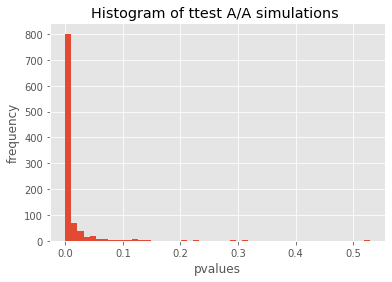

0.933

In [42]:
n = 100000
simulations = 1000
n_s = 1000
res = []



# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_ev_0.sample(n_s, replace = False).values
    s2 = df_ev_1.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

**Данные для проведения А/А теста в группах различаются, поэтому необходимо найти причину. Посмотрим какой показатель средней покупки по каждому экспериментальному варианту**

In [57]:
df_aa.groupby('experiment_variant', as_index=False) \
     .agg({'purchase':'mean'})
# Разница почти на 3 процента!

,experiment_variant,purchase
0,0,0.023945
1,1,0.053242


In [61]:
# Посмотрим какой процент продаж у разных версий
df_aa.groupby(['experiment_variant', 'version'], as_index=False) \
     .agg({'purchase':'mean'})
# Есть различия, надо разобраться почему?

,experiment_variant,version,purchase
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


In [62]:
# Посмотрим какой процент продаж у разных версий учитывая количество пользователей
df_aa.groupby(['experiment_variant', 'version'], as_index=False) \
     .agg({'purchase':'mean', 'experiment_variant':'count'}) \
     .rename(columns={'experiment_variant':'value'})

,version,purchase,value
0,v2.8.0,0.000993,41283
1,v2.9.0,0.074658,11921
2,v3.7.4.0,0.059943,4204
3,v3.8.0.0,0.057604,5694
4,v2.8.0,0.045606,41552
5,v2.9.0,0.071304,12033
6,v3.7.4.0,0.063018,4221
7,v3.8.0.0,0.062848,6110


**Из данных исследований видно, что отличия версии приложения, по которому была совершена покупка, влияют на наш тест. Посмотрим, что будет, если убрать данную версию приложения из нашего эксперимента. Создадим новые ДФ для проведения теста**

In [64]:
new_df_ev_0 = df_aa.query('experiment_variant == 0 & version != "v2.8.0"').purchase

In [65]:
new_df_ev_1 = df_aa.query('experiment_variant == 1 & version != "v2.8.0"').purchase

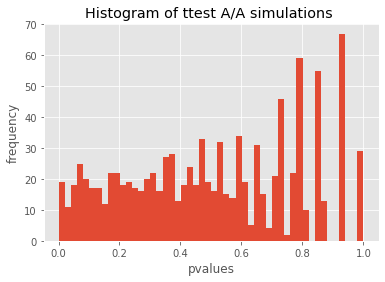

0.039

In [66]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = new_df_ev_0.sample(n_s, replace = False).values
    s2 = new_df_ev_1.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

### Проведя аналитику было выявлено, что конверсия по версии приложения "v2.8.0" значительно отличается между экспериментальными группами 1 и 0. Исключив из теста данную версию продукта мы получили необходимое значение меньше значения альфа.